# Yahoo Stock Price

# Introduction

This is a dataset of Microsoft Stock price taken from Kaggle [1].

"Stocks and financial instrument trading is a lucrative proposition. Stock markets across the world facilitate such trades and thus wealth exchanges hands. Stock prices move up and down all the time and having ability to predict its movement has immense potential to make one rich.
Stock price prediction has kept people interested from a long time. There are hypothesis like the Efficient Market Hypothesis, which says that it is almost impossible to beat the market consistently and there are others which disagree with it." - Kaggle introduction of Yahoo Data Set [2]

The Data set is coumposed of 7 columns :
- Date -> Date of the information
- High -> Highest Price of the stock for that particular date.
- Low -> Lowest Price of the stock for that particular date.
- Open -> Opening Price of the stock.
- Close -> Closing Price of the stock.
- Volume -> Total amount of Trading Activity.
- AdjClose -> Adjusted values factor in corporate actions such as dividends, stock splits, and new share issuance.

## Import of Libraries and Data

In [68]:
#Import libraries of data manipulation & visualization

#import data manipulation libraries
import os
import numpy as np 
import pandas as pd 
import math
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
import plotly_express as px
from sklearn.preprocessing import MinMaxScaler

#import parallelization libraries
from multiprocessing.pool import ThreadPool
import multiprocessing as mp
import time

#import the test-libraries
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

#Import the prediction libraries
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import Dense, LSTM
from prophet import Prophet

In [69]:
# Fix the number of CPU used :
nCPU = os.cpu_count()
pool = ThreadPool(processes=nCPU)

In [70]:
# Import DataSet
path = os.path.abspath("./Data/Microsoft_Stock.csv")
def import_df(file_name):
    df_xlsx = pd.read_csv(file_name)
    return df_xlsx
Primary_df = pool.apply_async(import_df, (path, )).get() 

In [71]:
fig = px.line(df, x=df.index, y='Close', title='Microsoft Stock Price',labels={'Close':'Closing Price ($)'})
fig.update_layout(title_text='Microsoft Stock Price', title_x=0.5)
fig

## Data presentation

In [72]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...
2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455


In [73]:
print(f"The dataframe begins at : {df.index.min()}, and finish at : {df.index.max()}.")

The dataframe begins at : 2015-04-01 16:00:00, and finish at : 2021-03-31 16:00:00.


In [74]:
print(f"The dataframe contains {df.shape[0]} rows and {df.shape[1]} columns")

The dataframe contains 1511 rows and 5 columns


In [75]:
df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

We have no null values so it is cool.

# Data visualization

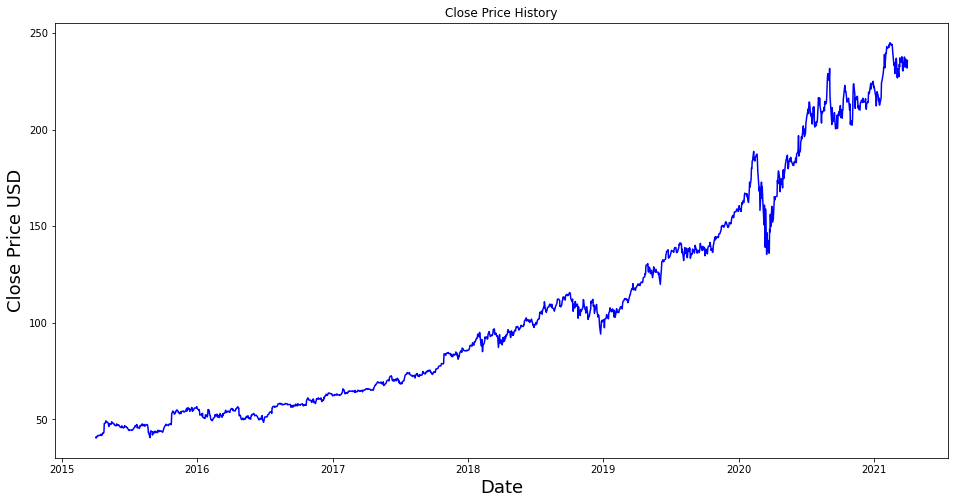

In [76]:
#plotting the data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'], color='blue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.show()

- There was an increase in the stock price from 2017 to 2020.
- The stock price fell at the beginning of 2020 because of Covid.
- The stock prices increased again at the second quarter.

# ARIMA Model

I did this part thanks to the videos [3], [4] and my school knowledges. 

Three factors define ARIMA model, it is defined as ARIMA(p,d,q) where p, d, and q denote
- p is the order of the AR term or the number of lagged (or past) observations to consider for autoregression. 
- d is the number of differencing required to make the time series stationary
- q is the order of the MA term


## D - ADF Test

Autoregressive models are conceptually similar to linear regression, the assumptions made by the latter hold here as well. Time series data must be made stationary to remove any obvious correlation and collinearity with the past data. In stationary time-series data, the properties or value of a sample observation does not depend on the timestamp at which it is observed. [5]

$$y_t' = y_t - y_{t-1} = y_t - B y_t = (1-B)y_t$$ 
where B denotes the backshift operator

We will use the augmented dickey fuller (ADF) test to check if the serie is stationnary.

The null hypothesis of the ADF test is that the time series is non-stationnary. So, if the p-value of the test is upper than the significance level then we can reject the null hypothesis and infer that the time serie is indeed stationnary.

In [77]:
result_adf = adfuller(df.Close)
print(f"ADF Statistics: {result_adf[0]}")
print(f"p-value: {result_adf[1]}")

ADF Statistics: 1.737136289927098
p-value: 0.9982158366942122


The serie is not stationnary. We'll need to differentiate once to see.

In [78]:
diff = df.Close.diff().dropna()
result_adf1 = adfuller(diff)
print(f"ADF Statistics: {result_adf1[0]}")
print(f"p-value: {result_adf1[1]}")

ADF Statistics: -10.038331065146412
p-value: 1.5195939917530848e-17


We can also go quicker and use this package which gives us the number of difference we need.

In [79]:
d_optimum = ndiffs(df.Close.dropna(),test="adf")
print(f"The ARIMA model need {d_optimum} difference.")

The ARIMA model need 1 difference.


## P - PACF

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors.

The below equation shows a typical autoregressive model. As the name suggests, the new values of this model depend purely on a weighted linear combination of its past values. Given that there are p past values, this is denoted as AR(p) or an autoregressive model of the order p. Epsilon ($\epsilon$) indicates the white noise.

$$Y_t = \alpha  + \beta_1 Y_{t-1} + \beta_2 Y_{t-2} + ... + \beta_p Y_{t-p} + \epsilon_1$$

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. [5]

c:\Users\33646\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



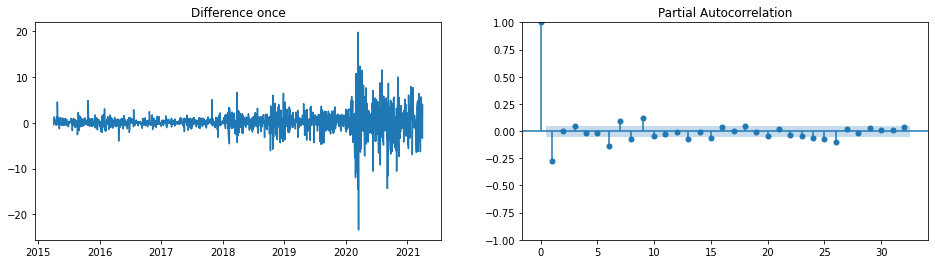

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")

plot_pacf(diff, ax=ax2);


## Q - ACF

q is the order of the moving average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA model.

Here, the future value $Y_t$ is computed based on the errors $\epsilon_t$ made by the previous model. So, each successive term looks one step further into the past to incorporate the mistakes made by that model in the current computation. Based on the window we are willing to look past, the value of q is set. Thus, the below model can be independently denoted as a moving average order q or simply MA(q).

$$y_t = \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ... + \theta_q \epsilon_{t-q}$$

We can look at the ACF plot for the number of MA terms. [5]

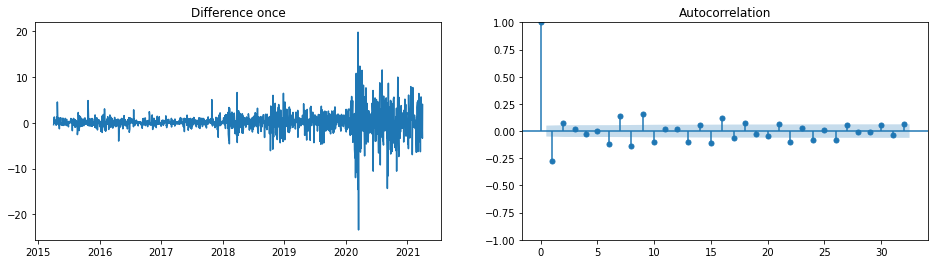

In [81]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("Difference once")

plot_acf(diff, ax=ax2);

## Fitting the ARIMA Model

In [82]:
#We ll cut the dataset in a training and a testing set
n = int(len(df) * 0.8)
train_arima = df.Close[:n]
test_arima = df.Close[n:]

In [83]:
arima_model = ARIMA(df.Close, order=(2,1,2))
result_ARIMA = arima_model.fit()

c:\Users\33646\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\33646\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\33646\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [84]:
print(result_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1511
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3377.962
Date:                Sat, 03 Dec 2022   AIC                           6765.924
Time:                        02:21:56   BIC                           6792.524
Sample:                             0   HQIC                          6775.830
                               - 1511                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0005      0.144     -0.003      0.997      -0.283       0.282
ar.L2         -0.2010      0.063     -3.199      0.001      -0.324      -0.078
ma.L1         -0.2656      0.146     -1.820      0.0

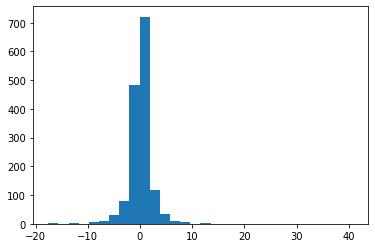

In [85]:
#plot residual errors
residuals_arima = pd.DataFrame(result_ARIMA.resid)
plt.hist(residuals_arima, bins=30);

## Forecast of the ARIMA model

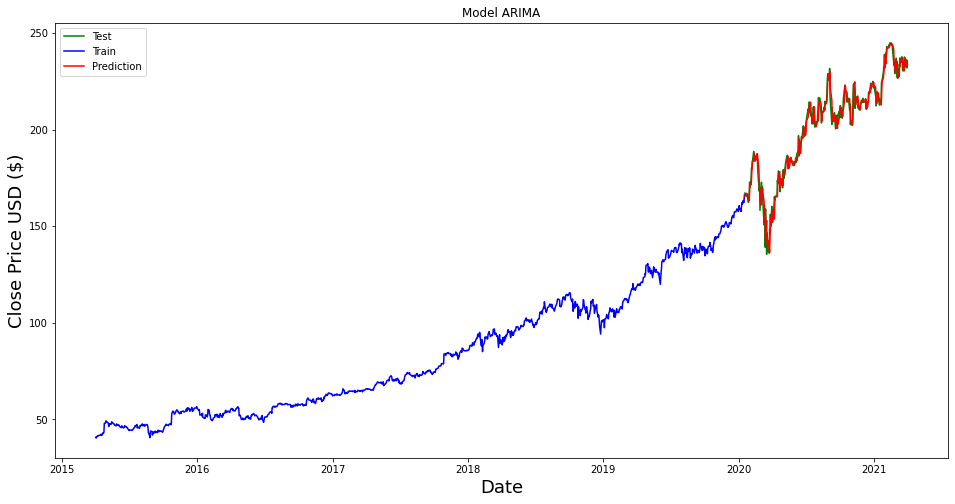

In [86]:

Prediction_arima = result_ARIMA.predict(len(train_arima), len(train_arima)+len(test_arima)-1, typ='levels', alpha = 0.05)
#plot fitted values
plt.figure(figsize=(16,8))
plt.title("Model ARIMA")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(test_arima, color='green', label='Test')
plt.plot(train_arima, color='blue', label='Train')
#plot the legend
plt.plot(Prediction_arima, color='red', label='Prediction')
plt.legend(loc="upper left")

# 

# LSTM

I did this part thanks to the video [6]

In this part, we will use an artificial recurrent neural network called Long Short Term Memory(LSTM).

Recently, deep learning-based algorithms such as Recurrent Neural Networks (RNN) and its special kind Long Short-Term Memory Networks (LSTM) have gained much attention with applications in various areas. While maintaining RNN’s ability to learn the temporal dynamics of a sequential data, LSTM can furthermore handle the vanishing and exploding gradients problem [7].

According to Korstanje in his book, Advanced Forecasting with Python: “The LSTM cell adds long-term memory in an even more performant way because it allows even more parameters to be learned. This makes it the most powerful [Recurrent Neural Network] to do forecasting, especially when you have a longer-term trend in your data. LSTMs are one of the state-of-the-art models for forecasting at the moment,” (2021) [8]

What is a neural network ?

A neural network is a structure of layer of neural network connected. It is not an algorithm but a combination of algorithms which allow us to do complex operations on the data.

What is a recurrent neural network ?

There is a class of neural network concepted to treat time series. The neurals of RNN have cellular memory, and the input is taken depending on this internal state, which is realized thanks to the loops of the neural network. It exists reccurent module of "tanh" layers in the RNN which allow them to keep the information. However, not for a long time, this is why we need LSTM.

What is LSTM ?

This is a particular type of recurrent neural network which is able to learn dependencie over long time on the data. This is done because the recurent module of the model has a combination of 4 layers interacting between each other.[9]


## Data treatment


In [87]:
#We ll cut the dataset in a training and a testing set
#scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.Close.values.reshape(-1,1))

In [88]:
train_LSTM = scaled_data[:n]
test_LSTM = scaled_data[n - 60:,:]
#split the data into x_train and y_train dataset
x_train_LSTM = []
y_train_LSTM = []

for i in range(60, len(train_LSTM)):
    x_train_LSTM.append(train_LSTM[i-60:i, 0])
    y_train_LSTM.append(train_LSTM[i, 0])
    if i <= 60:
        print(x_train_LSTM)
        print(y_train_LSTM)
        print()
        
x_test_LSTM = []
y_test_LSTM =  df.Close.values[n:]

for i in range(60,len(test_LSTM)):
    x_test_LSTM.append(test_LSTM[i-60:i, 0])

[array([0.00210064, 0.        , 0.00615535, 0.00605765, 0.00552027,
       0.00581339, 0.00698583, 0.00718124, 0.00664387, 0.00962384,
       0.00913532, 0.00649731, 0.01279922, 0.01148021, 0.01319003,
       0.01489985, 0.0370298 , 0.03781143, 0.0433317 , 0.04284319,
       0.0407914 , 0.04088911, 0.03883732, 0.0357108 , 0.02926234,
       0.03131412, 0.03644358, 0.0345872 , 0.0344895 , 0.03585735,
       0.04118222, 0.03913043, 0.03771373, 0.03561309, 0.03561309,
       0.03483146, 0.03229116, 0.03077675, 0.03575965, 0.03497802,
       0.03209575, 0.03390327, 0.03238886, 0.0320469 , 0.02965315,
       0.02857841, 0.02657548, 0.02618466, 0.03087445, 0.03004397,
       0.02774792, 0.02535418, 0.027064  , 0.02774792, 0.03141182,
       0.028383  , 0.02901808, 0.02745481, 0.02613581, 0.02618466])]
[0.02427943331704932]



In [89]:
#convert the x_train and y_train to numpy arrays
x_train_LSTM, y_train_LSTM = np.array(x_train_LSTM), np.array(y_train_LSTM)
x_test_LSTM = np.array(x_test_LSTM)

In [90]:
#Reshape the data
x_train_LSTM = np.reshape(x_train_LSTM, (x_train_LSTM.shape[0], x_train_LSTM.shape[1], 1))
print(x_train_LSTM.shape)
x_test_LSTM = np.reshape(x_test_LSTM, (x_test_LSTM.shape[0], x_test_LSTM.shape[1], 1))


(1148, 60, 1)


## Build the LSTM Model

In [91]:
#Build the LSTM model
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_LSTM.shape[1], 1)))
model_LSTM.add(LSTM(units=50, return_sequences=False))
model_LSTM.add(Dense(units=25))
model_LSTM.add(Dense(units=1))

In [92]:
#Compile the model
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [93]:
#Train the model
model_LSTM.fit(x_train_LSTM, y_train_LSTM, batch_size=1, epochs=1)

1148/1148 [==============================] - 23s 16ms/step - loss: 5.5670e-04


In [94]:
#Get the model's predicted values
predictions_LSTM = model_LSTM.predict(x_test_LSTM)
predictions_LSTM = scaler.inverse_transform(predictions_LSTM)

10/10 [==============================] - 1s 10ms/step


In [95]:
#Get the root mean squared error
rmse_LSTM = np.sqrt(np.mean(((predictions_LSTM - y_test_LSTM)**2)))
rmse_LSTM

34.77378254197453

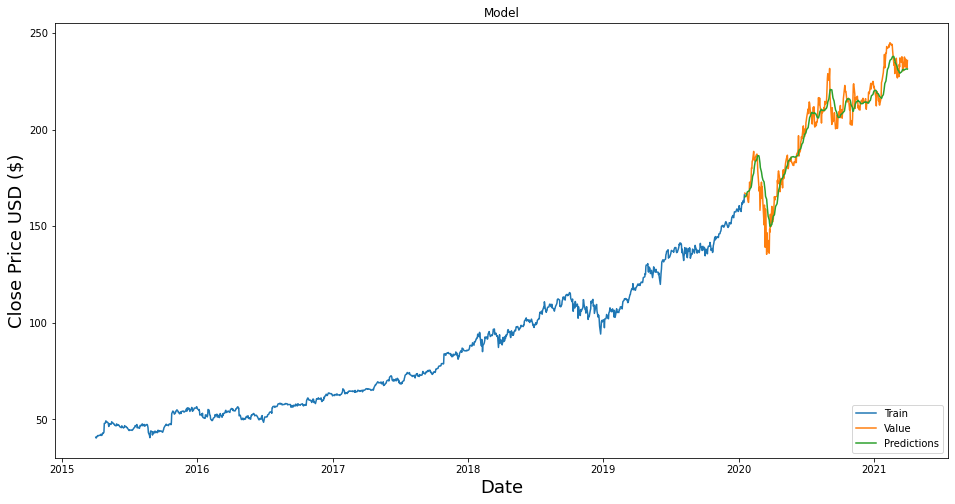

In [13]:
#plot the data
train = df.Close[:n]
valid = df.Close[n:]
valid = pd.DataFrame(valid)
valid["Predictions"] = predictions_LSTM
valid

#Visualize the data
plt.figure(figsize=(16,8))
plt.title("Model LSTM")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Close Price USD ($)", fontsize=18)
plt.plot(train)
plt.plot(valid[["Close","Predictions"]])
plt.legend(['Train', 'Value', 'Predictions'], loc='lower right')
plt.show()

In [97]:
def train_LSTM(df):
    model_LSTM = Sequential()
    model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(x_train_LSTM.shape[1], 1)))
    model_LSTM.add(LSTM(units=50, return_sequences=False))
    model_LSTM.add(Dense(units=25))
    model_LSTM.add(Dense(units=1))
    model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
    model_LSTM.fit(x_train_LSTM, y_train_LSTM, batch_size=1, epochs=1)
    predictions_LSTM = model_LSTM.predict(x_test_LSTM)
    predictions_LSTM = scaler.inverse_transform(predictions_LSTM)
    train = df.Close[:n]
    valid = df.Close[n:]
    valid = pd.DataFrame(valid)
    valid["Predictions"] = predictions_LSTM
    return valid, predictions_LSTM

import signal

def init_worker():
    ''' Add KeyboardInterrupt exception to mutliprocessing workers '''
    signal.signal(signal.SIGINT, signal.SIG_IGN)


In [101]:


pool = mp.Pool(4, init_worker)
pool.apply_async(train_LSTM, (df, )).get()
pool


# Prophet Model

In [40]:
df["Close"].reset_index()

,Date,Close
0,2015-04-01 16:00:00,40.72
1,2015-04-02 16:00:00,40.29
2,2015-04-06 16:00:00,41.55
3,2015-04-07 16:00:00,41.53
4,2015-04-08 16:00:00,41.42
...,...,...
1506,2021-03-25 16:00:00,232.34
1507,2021-03-26 16:00:00,236.48
1508,2021-03-29 16:00:00,235.24
1509,2021-03-30 16:00:00,231.85


In [43]:
prophet = Prophet()
#rename data columns
prophet.fit(df["Close"].reset_index().rename(columns={"Date":"ds", "Close":"y"}))
[10] Inclure RMSE et MSE

02:02:11 - cmdstanpy - INFO - Chain [1] start processing
02:02:12 - cmdstanpy - INFO - Chain [1] done processing


# Bibliographie :
- [1] https://www.kaggle.com/datasets/vijayvvenkitesh/microsoft-stock-time-series-analysis
- [2] https://www.kaggle.com/datasets/arashnic/time-series-forecasting-with-yahoo-stock-price
- [3] https://www.youtube.com/watch?v=gqryqIlvEoM&t=0s&ab_channel=DecisionForest
- [4] https://www.youtube.com/watch?v=JMT1eGJ9c2M&t=241s&ab_channel=DecisionForest
- [5] https://www.projectpro.io/article/how-to-build-arima-model-in-python/544
- [6] https://www.youtube.com/watch?v=QIUxPv5PJOY&ab_channel=ComputerScience
- [7] https://blog.engineering.publicissapient.fr/2020/09/23/long-short-term-memory-lstm-networks-for-time-series-forecasting/
- [8] https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf
- [9] https://getdoc.wiki/Time-series-lstm-model
- [10] https://facebook.github.io/prophet/docs/quick_start.html
